In [3]:
import numpy as np 
import torch 
import torch.nn as nn 
import torch.optim as optim
from torch.utils.data import TensorDataset, DataLoader
from matplotlib import pyplot as plt

In [4]:
%%capture

from extractor import get_dataset

path = 'dataset/games.pgn'
num_games = 500
device ='cuda'

X, Y = get_dataset(path, num_games=num_games, device=device)

In [5]:
X.shape, Y.shape

(torch.Size([43408, 773]), torch.Size([43408]))

In [6]:
def view_matrix(x):
    img = torch.zeros((784))
    img[:x.shape[0]] = x.to(device).detach().clone()
    plt.imshow(img.view(28,28),cmap='gray')

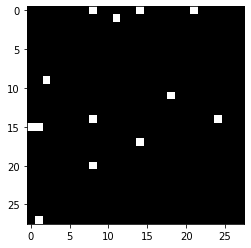

In [7]:
view_matrix(X[69])

In [8]:
class Autoencoder(nn.Module):
    def __init__(self):
        super().__init__()
        
        self.encoder = nn.Sequential(
            nn.Linear(773,100),
            nn.ReLU(),
            nn.Linear(100,100),
            nn.ReLU(),
            nn.Linear(100,100)
        )

        self.decoder = nn.Sequential(
            nn.Linear(100,100),
            nn.ReLU(),
            nn.Linear(100,100),
            nn.ReLU(),
            nn.Linear(100,773),
            nn.Sigmoid()
        )
    
    def forward(self, x):
        x = self.encoder(x)
        return self.decoder(x)


In [9]:
dataset = TensorDataset(X,Y)
loader = DataLoader(dataset, batch_size=64, shuffle=True)

In [10]:
model = Autoencoder().to(device)
criterion = nn.MSELoss()
optimizer = optim.SGD(model.parameters(),lr=0.1)

In [11]:
epochs = 10
outputs = []
losses = []

for epoch in range(epochs):
    running_loss = 0
    for batch, (x, _) in enumerate(loader):
        out = model(x)
        if batch == 0: outputs.append((x[0],out[0]))
        loss = criterion(out,x)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        running_loss += loss.item()

        if batch % (num_games//10) == (num_games//10) - 1:
            print(f'[{epoch + 1}, {batch + 1:5d}] loss: {running_loss / (num_games//10):.3f}')
            running_loss = 0.0
    losses.append(running_loss)
print('finished_training')

[1,    50] loss: 0.250
[1,   100] loss: 0.249
[1,   150] loss: 0.249
[1,   200] loss: 0.248
[1,   250] loss: 0.248
[1,   300] loss: 0.247
[1,   350] loss: 0.246
[1,   400] loss: 0.246
[1,   450] loss: 0.245
[1,   500] loss: 0.245
[1,   550] loss: 0.244
[1,   600] loss: 0.243
[1,   650] loss: 0.243
[2,    50] loss: 0.242
[2,   100] loss: 0.241
[2,   150] loss: 0.240
[2,   200] loss: 0.239
[2,   250] loss: 0.238
[2,   300] loss: 0.237
[2,   350] loss: 0.236
[2,   400] loss: 0.235
[2,   450] loss: 0.233
[2,   500] loss: 0.232
[2,   550] loss: 0.230
[2,   600] loss: 0.228
[2,   650] loss: 0.226
[3,    50] loss: 0.221
[3,   100] loss: 0.217
[3,   150] loss: 0.212
[3,   200] loss: 0.206
[3,   250] loss: 0.198
[3,   300] loss: 0.187
[3,   350] loss: 0.170
[3,   400] loss: 0.146
[3,   450] loss: 0.112
[3,   500] loss: 0.075
[3,   550] loss: 0.049
[3,   600] loss: 0.036
[3,   650] loss: 0.031
[4,    50] loss: 0.027
[4,   100] loss: 0.026
[4,   150] loss: 0.026
[4,   200] loss: 0.025
[4,   250] 

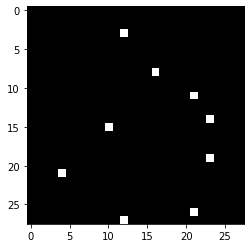

In [12]:
view_matrix(outputs[9][0]) 

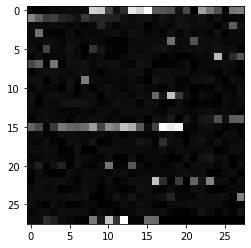

In [13]:
view_matrix(outputs[9][1])

In [14]:
e1 = model.encoder
e2 = model.encoder

In [15]:
a, b = X[0], X[1]
a, b = e1(a), e2(b)
r = torch.cat((a,b),dim=0)
r.shape

torch.Size([200])

In [68]:
class DeepChess(nn.Module):
    def __init__(self):
        super().__init__()
        self.e1 = model.encoder.share_memory()
        self.e2 = model.encoder.share_memory()
        self.fc1 = nn.Linear(200,100)
        self.fc2 = nn.Linear(100,100)
        self.fc3 = nn.Linear(100,2)

    def forward(self, x1, x2):
        x = torch.cat((self.e1(x1),self.e2(x2)),dim=-1)
        x = torch.relu(self.fc1(x))
        x = torch.relu(self.fc2(x))
        x = self.fc3(x)
        return x

net = DeepChess().to(device) 

In [69]:
net(X[0],X[1])

tensor([-0.0765, -0.0285], device='cuda:0', grad_fn=<AddBackward0>)

In [45]:
loader1 = DataLoader(dataset,batch_size=64,shuffle=True)
loader2 = DataLoader(dataset,batch_size=64,shuffle=True)

In [39]:
Y[0]

tensor(1., device='cuda:0')

In [40]:
a = torch.tensor([1,2,3,4,5])
torch.flip(a,dims=(0,))

tensor([5, 4, 3, 2, 1])

In [41]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(net.parameters(),lr=0.1)

In [70]:
epochs = 20
losses = []

for epoch in range(epochs):
    running_loss = 0
    for batch, (data1, data2) in enumerate(zip(loader1,loader2)):
        x1, y1 = data1
        x2, y2 = data2
        pred1 = net(x1,x2)
        pred2 = net(x2,x1)
        target1 = torch.tensor(torch.stack((y1,y2),dim=1))
        print(target1.shape)
        target2 = torch.flip(target1,dims=(0,))

        loss = criterion(pred1,target1)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        
        loss = criterion(pred2,target2)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        running_loss += loss.item()

        if batch % (num_games//10) == (num_games//10) - 1:
            print(f'[{epoch + 1}, {batch + 1:5d}] loss: {running_loss / (num_games//10):.3f}')
            running_loss = 0.0
    
    losses.append(running_loss)

print('finished_training')


torch.Size([64, 2])


/tmp/ipykernel_31900/1318026344.py:11: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  target1 = torch.tensor(torch.stack((y1,y2),dim=1))


RuntimeError: one of the variables needed for gradient computation has been modified by an inplace operation: [torch.cuda.FloatTensor [100, 100]], which is output 0 of AsStridedBackward0, is at version 6794; expected version 6793 instead. Hint: enable anomaly detection to find the operation that failed to compute its gradient, with torch.autograd.set_detect_anomaly(True).